# Signal Processing for Vibration Testing

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import control as ctrl
import matplotlib.pyplot as plt
import vibrationtesting as vt
import numpy as np
import scipy as sp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Here we create a state space model to use in an "experiment". We will sample it at 1 kHz, and add a bit of noise. The input is on degree of freedom 1 (state 3), with two displacement sensors, one at each degree of freedom.  

In [3]:
sample_freq = 1e3
noise_power = 0.001 * sample_freq / 2
A = sp.array([[0, 0, 1, 0],\
              [0, 0, 0, 1],\
              [-200, 100, -.2, .1],\
              [100, -200, .1, -.2]])
B = sp.array([[0], [0], [1], [0]])
C = sp.array([[35, 0, 0, 0], [0, 35, 0, 0]])
D = sp.array([[0], [0]])
sys = ctrl.ss(A, B, C, D)
tin = sp.linspace(0, 204.8, num = 2048, endpoint = False)
nr=.5   # Noise ratio. 0 is all noise on input

Now we simulate `num_exper` experiments. We also put some noise in the inputs and outputs after the simulation. Remember, we want to simulate measured inputs, to the noise on the input is the error in measuring that input. Likewise, noise is added to the output afterwards. If we had added noise to the input before the simulation, we would be simulating a known error in the input force. That's not nearly as hard to compensate for. 

In [9]:
if 'Yout' in vars(): del(Yout); del(Ucomb)  # Initialization line. 
num_exper = 25
for i in sp.arange(num_exper): #was 2*50
    u = np.random.normal(scale=sp.sqrt(noise_power), size=tin.shape)
    t, yout, xout = ctrl.forced_response(sys, tin, u,rtol=1e-12,transpose=False)
    if 'Yout' in locals():
        Yout=np.dstack((Yout,yout+nr*np.random.normal(scale=.050*np.std(yout), size=yout.shape)))
        Ucomb=np.dstack((Ucomb,u+(1-nr)*np.random.normal(scale=.05*np.std(u), size=u.shape)))
    else:
        # 5% half the noise on output as on input
        Yout=yout+nr*np.random.normal(scale=.050*np.std(yout[0,:]), size=yout.shape)
        # 10% noise signal on input
        Ucomb=u+(1-nr)*np.random.normal(scale=.05*np.std(u), size=u.shape)#(1, len(tin))) 

There are 2048 time steps. 

In [5]:
tin.shape

(2048,)

Note that there are two output channels, and 2048 points each. In matrix form, each row represents one channel of data. Each column it a snapshot in time of all of the sensors. 

In [26]:
yout.shape

(2, 2048)

That messy loop above also compiled each run separately in `Yout`. The number of individual experiments is represented by the 3rd dimension. This can be thought of as the depth into the page. If were were to average across all experiments, we average in the depth dimension. 

In [10]:
Yout.shape

(2, 2048, 25)

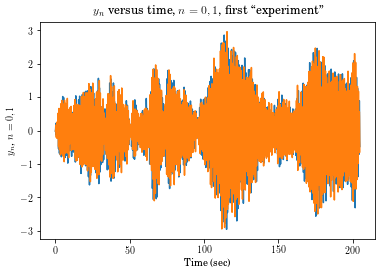

In [31]:
# Simultaneously plot all outputs resulting from the first excitation
# This really makes no practical sense to do... but this is how you do it. 
# Note that we have to swap axes since we want to plot along the 2nd dimension (1-index)
# but pyplot.plot plots along the 1st dimension (0-index). The notation used for data 
# makes more sense when plotting all outputs on the same dimension in the next cell. 
plt.plot(tin,np.swapaxes(Yout[:,:,0],0,1))
plt.xlabel('Time (sec)')
plt.ylabel('$y_n$, $n = 0, 1$')
plt.title('$y_n$ versus time, $n = 0, 1$, first ``experiment"');

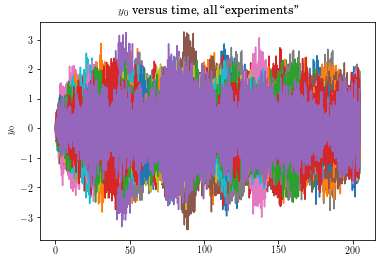

In [14]:
# Simultaneously plot all experiments as read from the first channel. 
plt.plot(tin,Yout[0,:,:])
plt.ylabel('$y_0$')
plt.title('$y_0$ versus time, all ``experiments"');

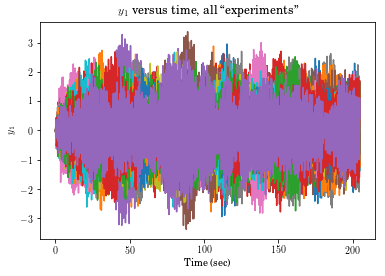

In [15]:
# Simultaneously plot all experiments as read from the second channel. 
plt.plot(tin, Yout[1,:,:])
plt.xlabel('Time (sec)')
plt.ylabel('$y_1$')
plt.title('$y_1$ versus time, all ``experiments"');

Due to the phenomenon called *leakage*, we often window the data. A common window used for such is the Hann window. You will often see if called hanning, but it was created by VonHann. There is a similar window, the *hamming* window by Hamming, which leads to the accidental mis-reference. 

The toolbox enables the user to directly obtain a window of the size necessary to window all data in all dimensions simply by using the raw data as an argument. Here one is plotted. They all will look the same, but the result is actually also a 2x2048x25 array. 

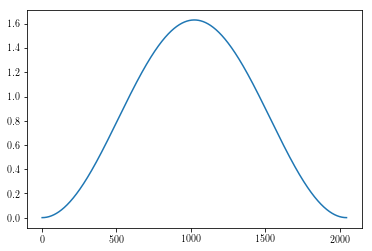

In [20]:
plt.plot(vt.hanning(Yout)[0,:,0]);

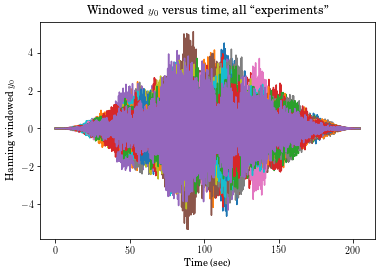

In [24]:
# Here we are windowing the first output. Note that [0,:,:] strips off the first dimension
# If hanning is applied to Yout[0,:,:] it may fail to operate as expected because the first 
# dimension (0) is now the time index, where Hanning expects it to be the second. 
plt.plot(tin, vt.hanning(Yout)[0,:,:]*Yout[0,:,:])
plt.xlabel('Time (sec)')
plt.ylabel('Hanning windowed $y_0$')
plt.title('Windowed $y_0$ versus time, all ``experiments"');

Text(0,0.5,'Response (all outputs, all experiments)')

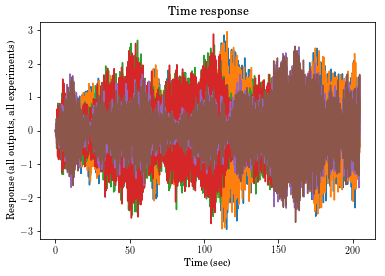

In [22]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2, for all outputs

plt.plot(tin,np.transpose(Yout[:,:,0]))
plt.plot(tin,np.transpose(Yout[:,:,1]))
plt.plot(tin,np.transpose(Yout[:,:,2]))
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)')

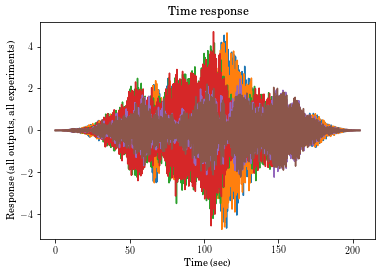

In [28]:
# Note that each layer is a new dataset. Here we plot 3 datasets on top of each other, 
# numbers 0, 1 and 2, for both channels

plt.plot(tin,np.transpose(vt.hanning(Yout[:,:,0])*Yout[:,:,0]));
plt.plot(tin,np.transpose(vt.hanning(Yout[:,:,1])*Yout[:,:,1]));
plt.plot(tin,np.transpose(vt.hanning(Yout[:,:,2])*Yout[:,:,2]));
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)');

Swapping axes temporarily to be compliant with                       expectations. I'll fix them in your result
Swapping axes temporarily to be compliant with                       expectations. I'll fix them in your result


Text(0,0.5,'Response (all outputs, all experiments)')

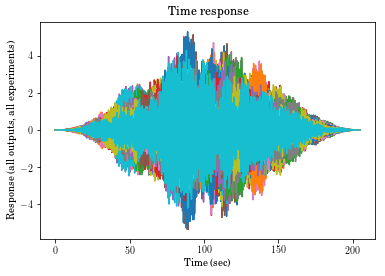

In [34]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2

plt.plot(tin,vt.hanning(Yout[0,:,:])*Yout[0,:,:])
plt.plot(tin,vt.hanning(Yout[1,:,:])*Yout[1,:,:])
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)')

In [47]:
Ywindowed[0,:,:].shape

(2048, 25)

In [49]:
Ywindowed[0,:,:].reshape(1,*Ywindowed[0,:,:].shape)

array([[[ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
           0.00000000e+00,  -0.00000000e+00,   0.00000000e+00],
        [  1.04209715e-07,  -2.29604319e-07,   1.54300749e-07, ...,
           9.81472892e-08,  -5.88807409e-07,   2.21969610e-07],
        [  2.59567654e-06,  -2.52310646e-06,  -9.67254856e-07, ...,
           5.05292704e-07,  -4.41190983e-06,  -4.01408357e-06],
        ..., 
        [  7.29951983e-06,   2.59046939e-06,   2.53385566e-05, ...,
           4.32654634e-06,  -9.72402792e-06,   2.06779988e-05],
        [ -1.14766033e-06,   1.61024854e-06,   4.34493995e-06, ...,
           4.80317332e-06,   2.89309047e-06,   2.06512948e-06],
        [ -1.17401443e-32,   5.99505461e-33,  -1.98208687e-33, ...,
           2.14089224e-32,   2.95174371e-32,  -1.63385237e-32]]])

Text(0,0.5,'Response (all outputs, all experiments)')

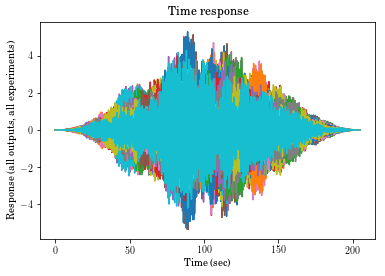

In [45]:
# Note that each layer is a new dataset. Here we plot all 3 datasets on top of each other, 
# numbers 0, 1 and 2

# The error here is that the three-dimensional arrays are reduced to two-dimensional 
# arrays by leaving them with only one row. 

Ywindowed = (vt.window(Yout, windowname = 'hanning')*Yout)
plt.plot(tin,Ywindowed[0,:,:])
plt.plot(tin,Ywindowed[1,:,:])
plt.title('Time response')
plt.xlabel('Time (sec)')
plt.ylabel('Response (all outputs, all experiments)');

Note: If there is only a single channel, and the data ends up with only a single row as a result, the windowing/plotting won't work exactly the same. To add a zeroth dimension (but with a value of 1), you can do this:

In [51]:
chan1 = np.expand_dims(Ywindowed[0,:,:], axis=0)


Let's look at a different window: the flattop window. 

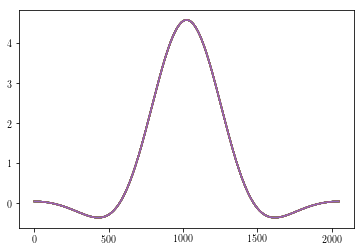

In [56]:
plt.plot(vt.window(Yout, windowname = 'flatwin')[0,:,:]);

Here we have obtained the fully windowed 3-dimensional array, but plotted only the first channel by calling only those rows with `[0,:,:]`.

In [57]:
# Let's find some cross and auto spectrum densities. 
# Better functions are likey to be those in scipy.signal. They use the periodogram method. 
# That method doesn't work for hammer excitation, but is otherwise likely better. 
freq_vec, Pxx = vt.asd(Yout, tin, windowname="hanning", ave=bool(True))
freq_vec, Pyy = vt.asd(Ucomb, tin, windowname="hanning", ave=bool(True))
freq_vec, Pxy = vt.crsd(sp.expand_dims(Yout[0,:,:],0), Ucomb, tin, windowname="hanning", ave=bool(True))


In [ ]:
We can plot the H2 and H1 FRFs. 

Text(0,0.5,'amplitude (dB)')

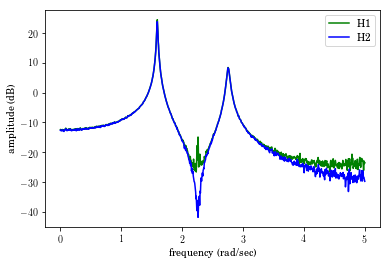

In [61]:
plt.plot(freq_vec,20*sp.log10(abs(Pxx[0,:]/Pxy[0,:])),'-g')
plt.plot(freq_vec,20*sp.log10(abs(Pxy[0,:]/Pyy[0,:])),'-b')
plt.legend(['H1','H2'])
plt.xlabel('frequency (rad/sec)')
plt.ylabel('amplitude (dB)');

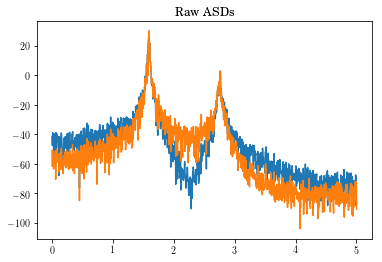

In [80]:
plt.plot(freq_vec, 20*sp.log10(Pxx[:,:].T))
plt.title('Raw ASDs')
plt.show()

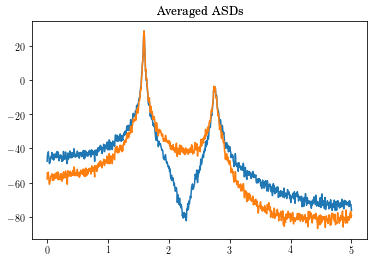

In [63]:
freq_vec, Pxx = vt.asd(Yout, tin, windowname="hanning", ave=bool(True))
plt.plot(freq_vec, 20*np.log10(Pxx).T)
plt.title('Averaged ASDs')
plt.show()

All of what we've done could have been performed with a single call to `frfest`. 

A fancier plotter is still coming into being: `frfplot`. The results are at the end. Right now it's more illustrative. Multiple plots can happen at the same time, but it's not as friendly as it needs to be. 

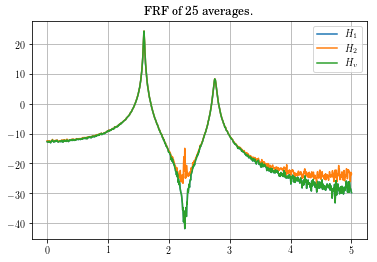

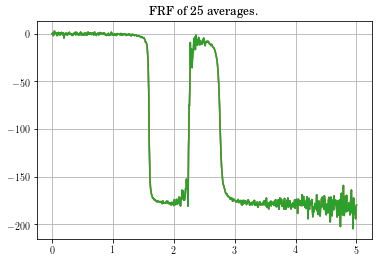

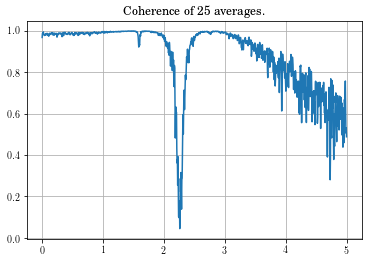

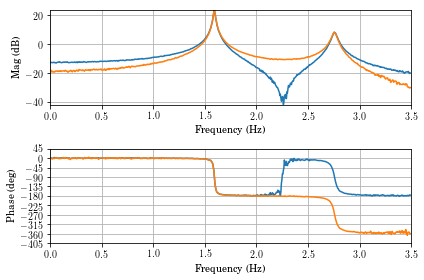

In [88]:
f, H1, H2, coh, Hv = vt.frfest(Yout, Ucomb, t, Hv=bool(True))
#fig_amp,=plt.plot(f[0,:],20*np.log10(np.abs(H1[0,:])),legend='$H_1$',f[0,:],20*np.log10(np.abs(H2[0,:])),legend='$H_2$',f[0,:],20*np.log10(np.abs(Hv[0,:])),legend='$H_v$')
(line1, line2, line3) = plt.plot(f,20*np.log10(np.abs(H1[0,:])),f,20*np.log10(np.abs(H2[0,:])),f,20*np.log10(np.abs(Hv[0,:]))) 
plt.title('FRF of ' + str(Yout.shape[2]) + ' averages.')
plt.legend((line1,line2,line3),('$H_1$','$H_2$','$H_v$'))
plt.grid()
plt.show()
plt.plot(f,180.0/np.pi*np.unwrap(np.angle(H1[0,:])),f,180.0/np.pi*np.unwrap(np.angle(H2[0,:])),f,180.0/np.pi*np.unwrap(np.angle(Hv[0,:]))) 
plt.title('FRF of ' + str(Yout.shape[2]) + ' averages.')
plt.grid()
plt.show()
plt.plot(f,coh[0,:])
plt.title('Coherence of ' + str(Yout.shape[2]) + ' averages.')
plt.grid()
plt.show()
vt.frfplot(f,H1,freq_max=3.5)

Looking at the coherence, you can see that the data in the vicinity of the zero is very bad. This might be something to be concerned about, but not overly alarmed about. 

We can use `frfplot` for a decent display with a bit of effort. However, the legend shows on the wrong plot. Note that the $H_1$, $H_2$, and $H_v$ FRFs always have identical phases, so the distinction is moot for phase. 

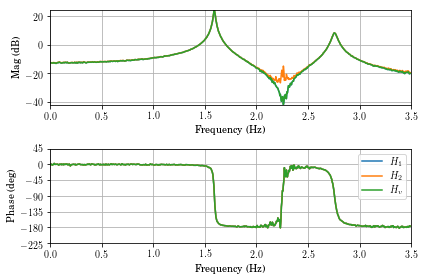

In [92]:
vt.frfplot(f,np.vstack((H1[0,:], H2[0,:], Hv[0,:])),freq_max=3.5)
plt.legend(['$H_1$','$H_2$','$H_v$'])
